In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Microsoft SC - Data Science/E-commerce Customers Segmentation Project/data.xlsx'

customers = pd.read_excel(file_path, sheet_name=0)
genders = pd.read_excel(file_path, sheet_name=1)
cities = pd.read_excel(file_path, sheet_name=2)
transactions = pd.read_excel(file_path, sheet_name=3)
branches = pd.read_excel(file_path, sheet_name=4)
merchants = pd.read_excel(file_path, sheet_name=5)

In [ ]:
customers_copy = customers.copy()
customers_copy.head()

,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


In [ ]:
genders_copy = genders.copy()
genders_copy.head()

,gender_id,gender_name
0,1,Male
1,2,Female


In [ ]:
cities_copy = cities.copy()
cities_copy.head()

,city_id,city_name
0,1,Cairo
1,2,Alexandria
2,3,Giza
3,4,Shubra El-Kheima
4,5,Port Said


In [ ]:
transactions_copy = transactions.copy()
transactions_copy.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [ ]:
branches_copy = branches.copy()
branches_copy.head()

,branch_id,merchant_id
0,1,11
1,2,18
2,3,8
3,4,15
4,5,9


In [ ]:
merchants_copy = merchants.copy()
merchants_copy.head()

,merchant_id,merchant_name
0,1,Rivas Group
1,2,Peters-Acosta
2,3,"Duran, Perry and Stout"
3,4,Morton Ltd
4,5,Curtis-Fields


## **Feature Selection**

**Demographic Features:** <br>
<code>gender_name</code> from genders table<br>
<code>city_name</code> from city table

**Transactional Features:**<br>
1- how frequently each customer used coupons (by counting the number of transactions per customer)<br>
2- check <code>transaction_status</code> from transactions table to see if a customer has frequently claimed coupons<br>
3- check <code>transaction_date</code> and <code>burn_date</code> to get the time since the last transaction


In [ ]:
# Merging demographic features
cust_info = pd.merge(customers_copy, genders_copy, on='gender_id', how='left')
cust_info = pd.merge(cust_info, cities_copy, on='city_id', how='left')

# Creating transactional features
transactional_behavior = transactions_copy.groupby('customer_id').agg(
    coupon_usage_frequency=('transaction_id', 'count'),
    transaction_status=('transaction_status', lambda x: (x == 'burnt').sum()),  # number of 'burnt' coupons
    last_transaction=('transaction_date', 'max')  # recency measure
).reset_index()

# Merge demographic and transactional data
customer_segmentation_data = pd.merge(cust_info, transactional_behavior, on='customer_id', how='left')

# Creating a feature for the recency of the last transaction by calculating the difference between the current date and last transaction date
customer_segmentation_data['recency'] = (pd.to_datetime('today') - pd.to_datetime(customer_segmentation_data['last_transaction'])).dt.days

# Dropping unnecessary columns
customer_segmentation_data.drop(['last_transaction', 'gender_id', 'city_id'], axis=1, inplace=True)

customer_segmentation_data.head()


,customer_id,join_date,gender_name,city_name,coupon_usage_frequency,transaction_status,recency
0,1,2022-01-08,Male,Mansoura,7.0,0.0,114.0
1,2,2023-05-02,Female,Sohag,3.0,0.0,332.0
2,3,2023-05-14,Male,Aswan,5.0,0.0,74.0
3,4,2022-11-25,Female,Ismailia,1.0,0.0,611.0
4,5,2023-04-26,Male,El-Mahalla El-Kubra,4.0,0.0,77.0


# **Model Development**

**Data Preprocessing**

1- one-hot encoding categorical features

In [ ]:
customer_segmentation_data = pd.get_dummies(customer_segmentation_data, columns=['gender_name', 'city_name'], drop_first=True)
customer_segmentation_data.head()

,customer_id,join_date,coupon_usage_frequency,transaction_status,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,1,2022-01-08,7.0,0.0,114.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,2,2023-05-02,3.0,0.0,332.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,3,2023-05-14,5.0,0.0,74.0,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,2022-11-25,1.0,0.0,611.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,5,2023-04-26,4.0,0.0,77.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
customer_segmentation_data.columns

Index(['customer_id', 'join_date', 'coupon_usage_frequency',
       'transaction_status', 'recency', 'gender_name_Male', 'city_name_Aswan',
       'city_name_Asyut', 'city_name_Beni Suef', 'city_name_Cairo',
       'city_name_Damanhur', 'city_name_Damietta',
       'city_name_El-Mahalla El-Kubra', 'city_name_Fayyum', 'city_name_Giza',
       'city_name_Ismailia', 'city_name_Mansoura', 'city_name_Minya',
       'city_name_Port Said', 'city_name_Qena', 'city_name_Shubra El-Kheima',
       'city_name_Sohag', 'city_name_Suez', 'city_name_Tanta',
       'city_name_Zagazig'],
      dtype='object')

**Filling missing values**

In [ ]:
customer_segmentation_data.fillna(0, inplace=True)

In [ ]:
customer_segmentation_data

,customer_id,join_date,coupon_usage_frequency,transaction_status,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,1,2022-01-08,7.0,0.0,114.0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,2,2023-05-02,3.0,0.0,332.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,3,2023-05-14,5.0,0.0,74.0,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,2022-11-25,1.0,0.0,611.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,5,2023-04-26,4.0,0.0,77.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2022-10-28,3.0,0.0,131.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
996,997,2022-07-07,3.0,0.0,238.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
997,998,2024-03-09,4.0,0.0,82.0,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
998,999,2022-07-16,4.0,0.0,161.0,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
customer_segmentation_data['join_date'] = pd.to_datetime(customer_segmentation_data['join_date'])

# Extract day, month, and year into 3 different columns
customer_segmentation_data['join_day'] = customer_segmentation_data['join_date'].dt.day
customer_segmentation_data['join_month'] = customer_segmentation_data['join_date'].dt.month
customer_segmentation_data['join_year'] = customer_segmentation_data['join_date'].dt.year

In [ ]:
customer_segmentation_data.drop(columns=['join_date'], inplace=True)
customer_segmentation_data.head()

,customer_id,coupon_usage_frequency,transaction_status,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,...,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig,join_day,join_month,join_year
0,1,7.0,0.0,114.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,8,1,2022
1,2,3.0,0.0,332.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,2,5,2023
2,3,5.0,0.0,74.0,True,True,False,False,False,False,...,False,False,False,False,False,False,False,14,5,2023
3,4,1.0,0.0,611.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,25,11,2022
4,5,4.0,0.0,77.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,26,4,2023


**Scaling the Features**

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_segmentation_data)

# **K-Means Clustering**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

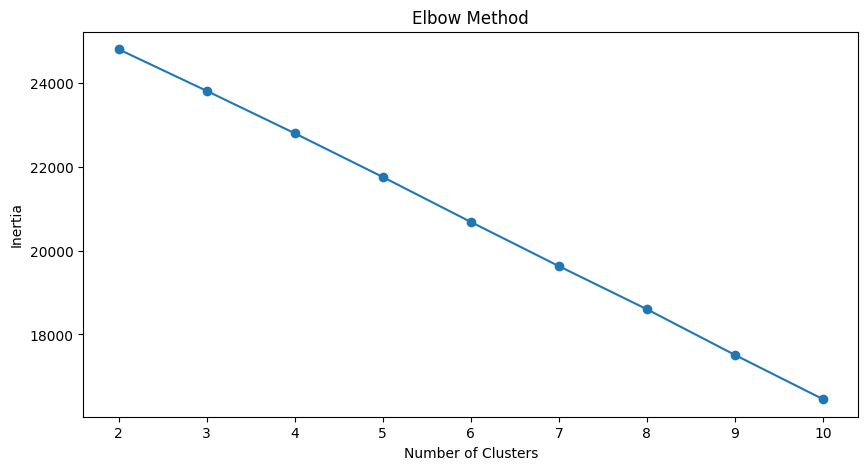

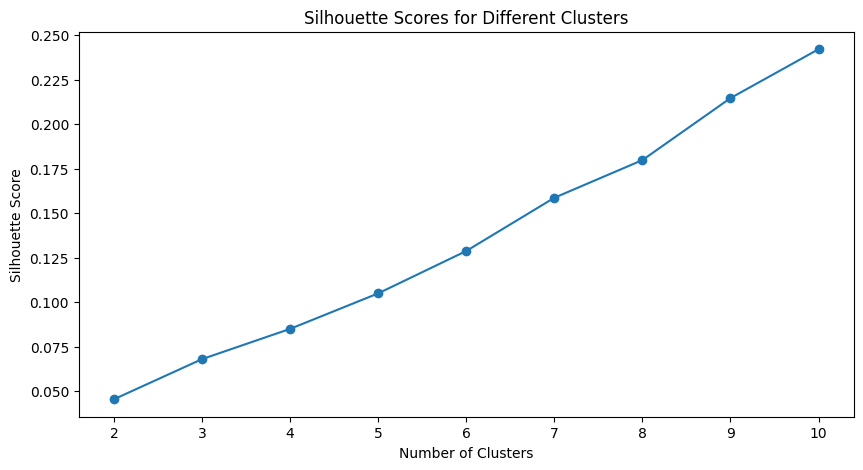

In [ ]:
# Exploring different numbers of clusters using the Elbow Method
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    # Calculate inertia (sum of squared distances to the nearest centroid)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score (how well clusters are separated)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


**Training the K-Means Model with Optimal Clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


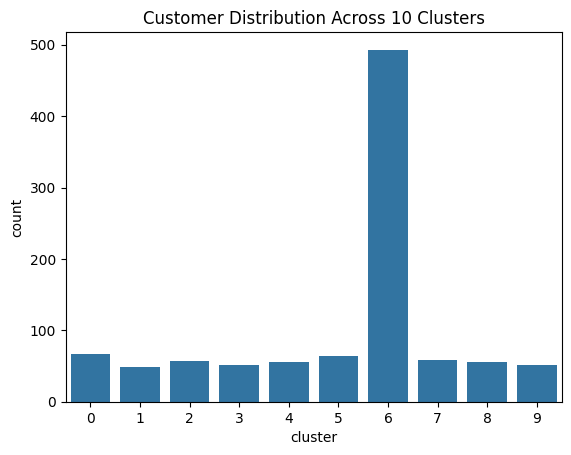

In [ ]:
k_optimal = 10
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(scaled_data)

# Adding the cluster labels to the dataset
customer_segmentation_data['cluster'] = kmeans.labels_

# Visualizing the cluster centers
centroids = kmeans.cluster_centers_

# Plotting the cluster distribution
sns.countplot(x='cluster', data=customer_segmentation_data)
plt.title(f'Customer Distribution Across {k_optimal} Clusters')
plt.show()


# **DBSCAN Clustering**

In [ ]:
# Check unique cluster labels
unique_labels = np.unique(dbscan_labels)
print(f"Unique labels assigned by DBSCAN: {unique_labels}")

Unique labels assigned by DBSCAN: [-1]


In [ ]:
# Increase eps and adjust min_samples
dbscan = DBSCAN(eps=4, min_samples=3)  # this ep value gave the highest silhouette score
dbscan_labels = dbscan.fit_predict(scaled_data)

# Check unique labels again
unique_labels = np.unique(dbscan_labels)
print(f"Unique labels after tuning DBSCAN: {unique_labels}")

# Only calculate silhouette score if there are more than 1 cluster
if len(unique_labels) > 1:
    print(f'Silhouette Score for DBSCAN: {silhouette_score(scaled_data, dbscan_labels)}')
else:
    print("DBSCAN still didn't find more than one cluster.")


Unique labels after tuning DBSCAN: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Silhouette Score for DBSCAN: 0.3872527839879116


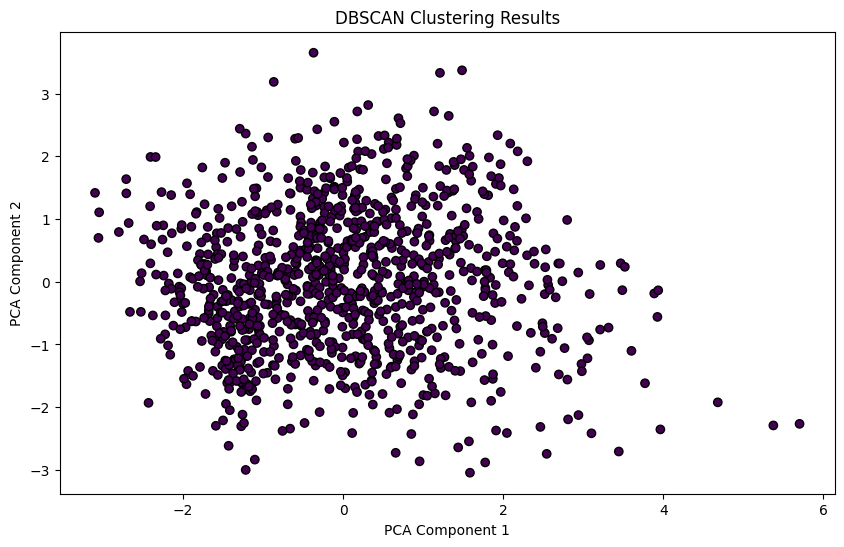

In [ ]:
# Reduce data to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot the DBSCAN results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for K-Means: 0.06793638004590705


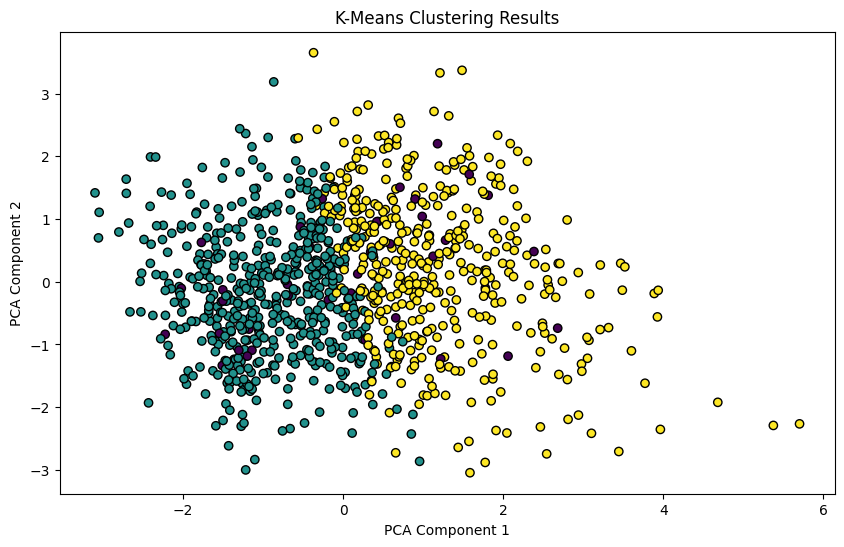

In [ ]:
# K-Means with 3 clusters (you can experiment with different values)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Silhouette score for K-Means
print(f'Silhouette Score for K-Means: {silhouette_score(scaled_data, kmeans_labels)}')

# Visualize K-Means clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()